In [1]:
import pickle
import sys
import os
sys.path.append("/".join(os.getcwd().split("/")[:-2]))
import common
import torch
from tqdm import tqdm

checkpoint_path = "/local/huzaifa/CoreInfer/models/opt-6.7b"
model_name = "opt-6.7b"
num_neurons = common.MODEL_INFO[model_name]["num_neurons"]
model, tokenizer, num_layers = common.load_model(model_name, 5, 27, checkpoint_path, "cpu", None)

/local/huzaifa/jupytervenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  4.40it/s]


Done. Loaded model in 0.65 seconds.



In [14]:
def load_sparsity_levels(dataset_name, dir_path):
    sparsity_levels = []
    dir_path = f"{dir_path}/{dataset_name}"
    for filename in os.listdir(dir_path):
        filepath = os.path.join(dir_path, filename)
        with open(filepath, "rb") as f:
            levels = pickle.load(f)
            sparsity_levels.append(levels)
            
    return sparsity_levels

In [18]:
def save_levels(levels, dataset_name, dir_path):
    levels_path = f"{dir_path}/{dataset_name}/"
    os.makedirs(os.path.dirname(levels_path), exist_ok=True)
    for i,l in enumerate(levels):
        with open(f"{levels_path}sparsity_levels{i}.pkl", "wb") as f:
            pickle.dump(l, f)

In [20]:
def draw_levels(levels, title, labels = None):
    import matplotlib.pyplot as plt
    import numpy as np

    # Create the plot
    plt.figure(figsize=(10, 6))
    # Create a colormap with distinct colors using HSV color space
    num_configs = len(levels)
    colors = plt.cm.rainbow(np.linspace(0, 1, num_configs))

    # Create different line styles to alternate between
    line_styles = ['-', '--', '-.', ':']
    line_widths = [1, 1.5, 2]

    # Create the plot with different combinations of colors, styles and widths
    for i in range(num_configs):
        style_idx = i % len(line_styles)
        width_idx = (i // len(line_styles)) % len(line_widths)
        
        if labels:
            label = labels[i]
        else:
            label = f'Sparsity_levels{i}'
        
        plt.plot(list(range(6, 27)), 
                levels[i][6:27],
                linestyle=line_styles[style_idx],
                color=colors[i],
                linewidth=line_widths[width_idx],
                label=label)

    # Add labels and title
    plt.xlabel('Layer Number')
    plt.xticks(range(6, 27, 1))
    plt.ylabel('Sparsity Level')
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=8)


    # Save the figure
    plt.tight_layout()
    plt.show()

In [16]:
import numpy as np
sparsity_levels_dir_path = "/local/huzaifa/CoreInfer/ignore/opt-6.7b_sparsity_levels_files/sparsity_levels/opt-6.7b"
def calculate_avg_levels(dataset_name):
    sparsity_levels = load_sparsity_levels(dataset_name, sparsity_levels_dir_path)
    sparsity_levels_array = np.array(sparsity_levels)
    avg_levels = np.mean(sparsity_levels_array, axis=0)

    return avg_levels

## Calculate AVG Levels

In [17]:
truthfulqa_avg_levels = calculate_avg_levels("truthfulqa_gen")
bertaqa_en_avg_levels = calculate_avg_levels("bertaqa_en")
squadv2_avg_levels = calculate_avg_levels("squadv2")
commonsense_qa_avg_levels = calculate_avg_levels("commonsense_qa")

## Save Levels

In [19]:
avg_sparsity_levels_path = "/local/huzaifa/CoreInfer/ignore/opt-6.7b_sparsity_levels_files/sparsity_levels_avg/opt-6.7b"

save_levels([truthfulqa_avg_levels], "truthfulqa_gen", avg_sparsity_levels_path)
save_levels([bertaqa_en_avg_levels], "bertaqa_en", avg_sparsity_levels_path)
save_levels([squadv2_avg_levels], "squadv2", avg_sparsity_levels_path)
save_levels([commonsense_qa_avg_levels], "commonsense_qa", avg_sparsity_levels_path)

## Compare Avg Levels for Each Dataset

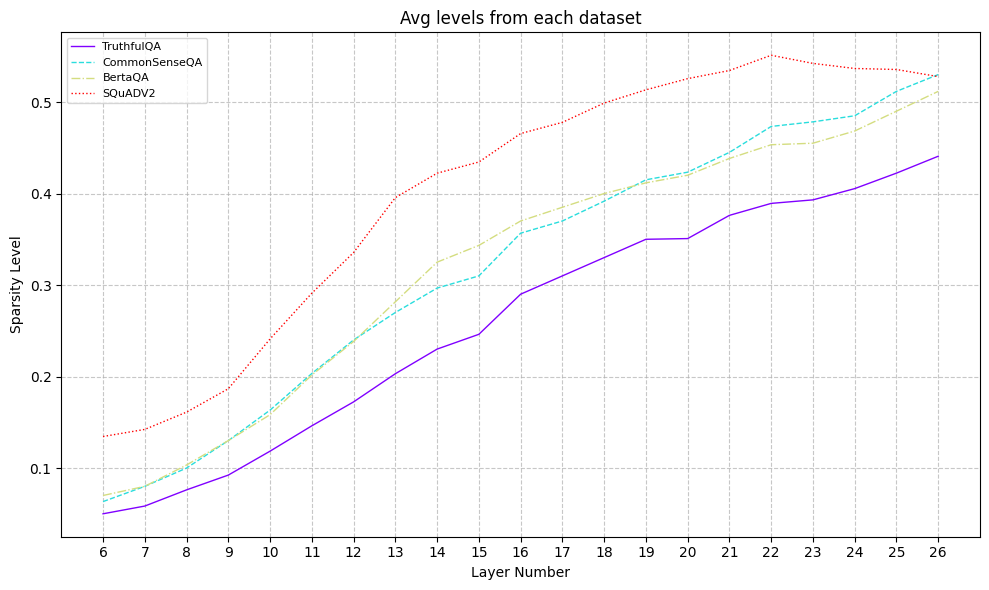

In [23]:
# Pick the first levels from each dataset
different_levels = [truthfulqa_avg_levels, commonsense_qa_avg_levels, bertaqa_en_avg_levels, squadv2_avg_levels]
draw_levels(different_levels, "Avg levels from each dataset", ["TruthfulQA", "CommonSenseQA", "BertaQA", "SQuADV2"])

## Actual Sparsity

In [3]:
import utils

output = utils.read_indecies_file("/local/huzaifa/CoreInfer/ignore/opt-6.7b_sparsity_levels_files/lm_eval_results_avg/indices_all.txt", model_name, 5, 27)

results = {}
for o in output:
    task_name = o["task_name"]
    if task_name not in results:
        results[task_name] = []
        
    results[task_name].append({
        'sparsity_name': o['sparsity_name'],
        'avg': o['avg']
    })
    
for key,value in results.items():
    value.sort(key=lambda x: x['sparsity_name'])
    print(f"\nTask: {key}")
    for v in value:
        print(f"{v['sparsity_name']}: {v['avg']}")


Task: commonsense_qa
sparsity_levels0.pkl: 0.3183679257347472

Task: bertaqa_en
sparsity_levels0.pkl: 0.3145319388253343

Task: truthfulqa_gen
sparsity_levels0.pkl: 0.2567182962117776

Task: squadv2
sparsity_levels0.pkl: 0.40249491440597973
